# Load the LGMR data (mean of the ensemble)

In [1]:
import xarray as xr
# open the 'LGMR_GMST_ens.nc' file
ds_sat = xr.open_dataset('data/LGMR_SAT_climo.nc')
ds_sat

c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, age: 120)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 100.0 300.0 500.0 ... 2.35e+04 2.37e+04 2.39e+04
Data variables:
    sat      (age, lat, lon) float32 ...
    sat_std  (age, lat, lon) float32 ...

# Crop the data for age>11

In [2]:

ds_sat = ds_sat.where(ds_sat.age>=11000, drop=True)

c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [3]:
ds_sat

<xarray.Dataset>
Dimensions:  (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 1.11e+04 1.13e+04 1.15e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat      (age, lat, lon) float32 -50.42 -50.41 -50.41 ... -41.98 -41.98
    sat_std  (age, lat, lon) float32 0.7924 0.7944 0.7947 ... 3.529 3.533 3.536

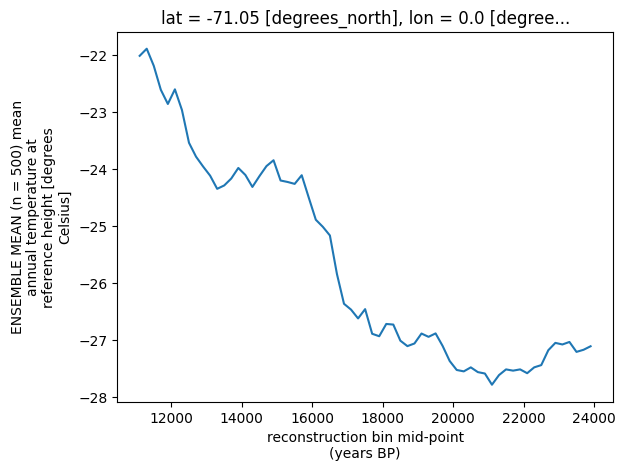

In [3]:
ds_sat['sat'].isel(lat=10).isel(lon=0).plot()


INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast.irreg(),set print.options = 0 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast.irreg(),      set quiet = 1 

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 53
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 (unknown unit)
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend       : False | I

c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\Rbeast\plotbeast.py:294: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


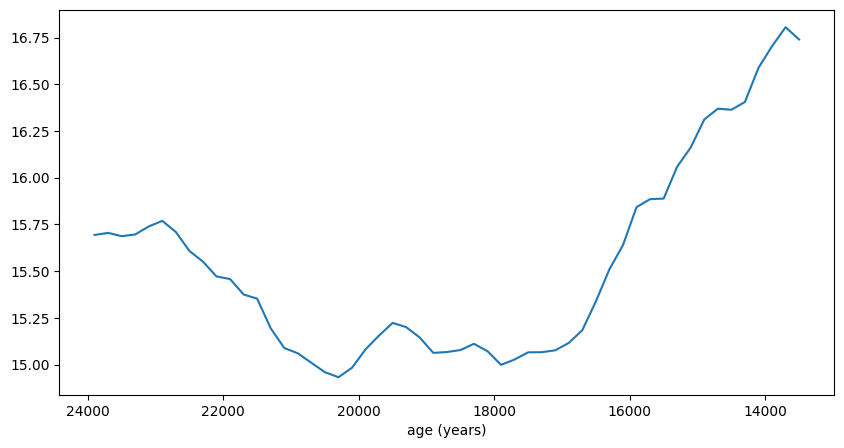

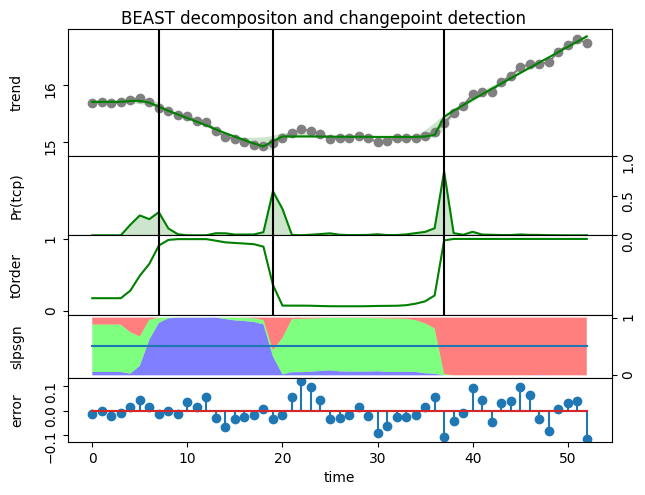

In [4]:
# cut the data according to interval_L_indx
data=ds_sat['sat'].isel(lat=35).isel(lon=0)


age=ds_sat['age'].values

interval_L_indx=12

data=data[interval_L_indx:]
age=age[interval_L_indx:]

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(age,data)
plt.xlabel('age (years)')
# invert the x-axis
plt.gca().invert_xaxis()


import numpy as np
import Rbeast as rb

# flip the data
data = data[::-1]

# start_age = ds_sat_EOFs['age'][-1].values
start_age=age[-1]
# print(start_age)

o = rb.beast(data, start=0, season='none')

rb.plot(o)

cps = o.trend.cp
# remove nan
cps = cps[~np.isnan(cps)]
print('cps',cps)

slpSgnPosPr=o.trend.slpSgnPosPr
slpSgnNposPr=1-slpSgnPosPr

slpSgnPosPr_list = [o.trend.slpSgnPosPr[int(cp)] for cp in cps]
# slpSgnZeroPr_list = [o.trend.slpSgnZeroPr[int(cp)] for cp in cps]
slpSgnNposPr_list = 1 - np.array(slpSgnPosPr_list) 

cp_age_list = [start_age - cp*200 for cp in cps]

# print('cp_age_list',cp_age_list)
# print('slpSgnPosPr',o.trend.slpSgnPosPr)
# print('slpSgnPosPr_list',slpSgnPosPr_list)


# sorted_indices = np.argsort(cp_age_list)[::-1]

# sorted_cp_age_list = np.array(cp_age_list)[sorted_indices].tolist()
# sorted_slpSgnPosPr_list = np.array(slpSgnPosPr_list)[sorted_indices].tolist()
# sorted_slpSgnZeroPr_list = np.array(slpSgnZeroPr_list)[sorted_indices].tolist()
# sorted_slpSgnNegPr_list = np.array(slpSgnNegPr_list)[sorted_indices].tolist()

# print('sorted_cp_age_list',sorted_cp_age_list)
# print('sorted_slpSgnPosPr_list',sorted_slpSgnPosPr_list)


flag = 'None'

# Checking the conditions for the change points
selected_cp_index = None
for i, (pos_pr, Npos_pr) in enumerate(zip(slpSgnPosPr_list, slpSgnNposPr_list)):
    # n=6
    # if cps[i]+n>np.max(cps):
    #     n=np.max(cps)-cps[i]
    if pos_pr >=0.1 and Npos_pr >=0.1:
        selected_cp_index = i
        print('selected_cp_index',selected_cp_index)
        print('pos_pr',Npos_pr)
        print('neg_pr',Npos_pr)
        flag = 'slope'
        break

# If no change point satisfies the condition, get the change point with the largest age
if selected_cp_index is None:
    selected_cp_index = np.argmax(cp_age_list)
    flag = 'maxage'

selected_cp_age = cp_age_list[selected_cp_index]
print('selected_cp_age',selected_cp_age)

# Center and weight the data

shape of the weight: (96,)
shape of the reshaped sat_centered_weighted: (65, 13824)


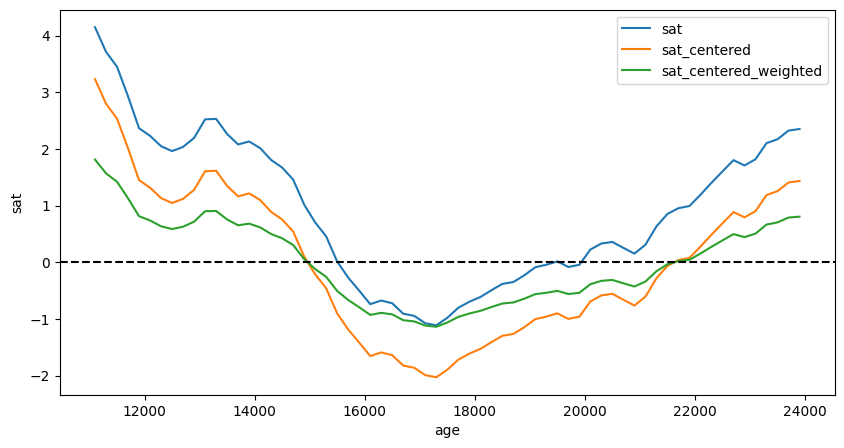

In [3]:
from toolbox import PCA_functions as pf
# 1. Center the Data
ds_sat = pf.center_data(ds_sat)

# 2. Weight the Data
ds_sat = pf.apply_weighting(ds_sat)

# 3. Plot the Centered and Weighted Data
lat_index = 77
lon_index = 90
pf.plot_sat_variables(ds_sat, lat_index, lon_index)


# PCA

shape of the reshaped sat_centered_weighted: (13824, 65)
shape of u, s, vh: (13824, 13824) (65,) (65, 65)
shape of EOFs: (13824, 2)
shape of PCs: (65, 2)
Explained variance: [8.98258686e-01 8.04840028e-02 7.40235392e-03 5.19952085e-03
 2.63320236e-03 2.17852276e-03 1.61866844e-03 7.41521362e-04
 3.43156047e-04 2.67069583e-04 2.14783169e-04 1.25641935e-04
 1.05506122e-04 8.99674415e-05 6.97138094e-05 5.73843863e-05
 4.11159162e-05 2.85841179e-05 2.40365462e-05 2.04937060e-05
 1.56445531e-05 1.33408384e-05 1.00197658e-05 9.03837099e-06
 8.46516286e-06 6.73880777e-06 5.06810420e-06 4.94178948e-06
 3.91775711e-06 3.26156487e-06 2.69328530e-06 2.56359567e-06
 1.72111925e-06 1.29166426e-06 1.08624761e-06 7.33775494e-07
 6.68961661e-07 6.38538950e-07 5.43628573e-07 4.89633464e-07
 4.49905457e-07 3.24484660e-07 2.99716788e-07 2.64120160e-07
 2.16782738e-07 1.99238471e-07 1.74655526e-07 1.58337343e-07
 1.42285387e-07 1.23404902e-07 1.21093862e-07 9.92318832e-08
 9.25580537e-08 7.17794606e-08 6.

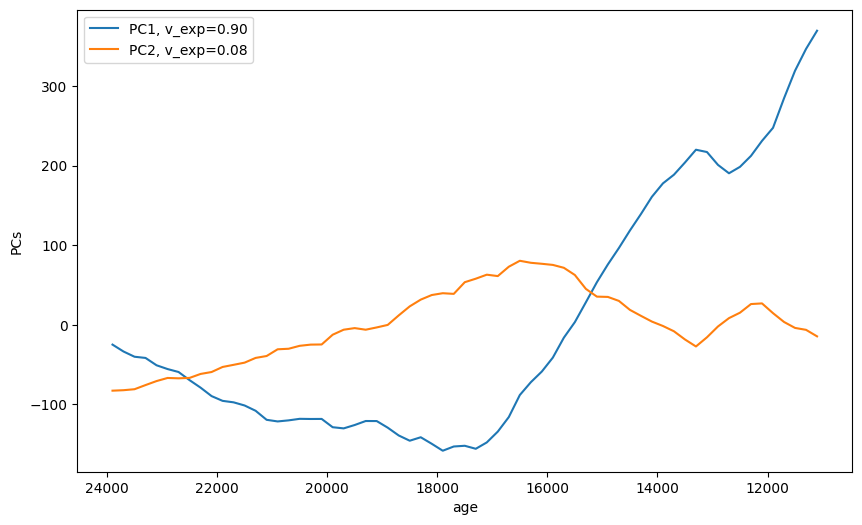

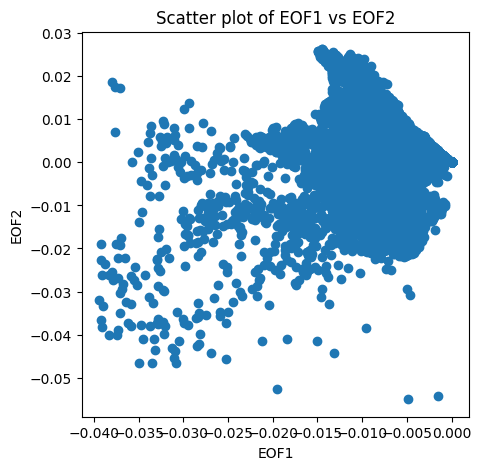

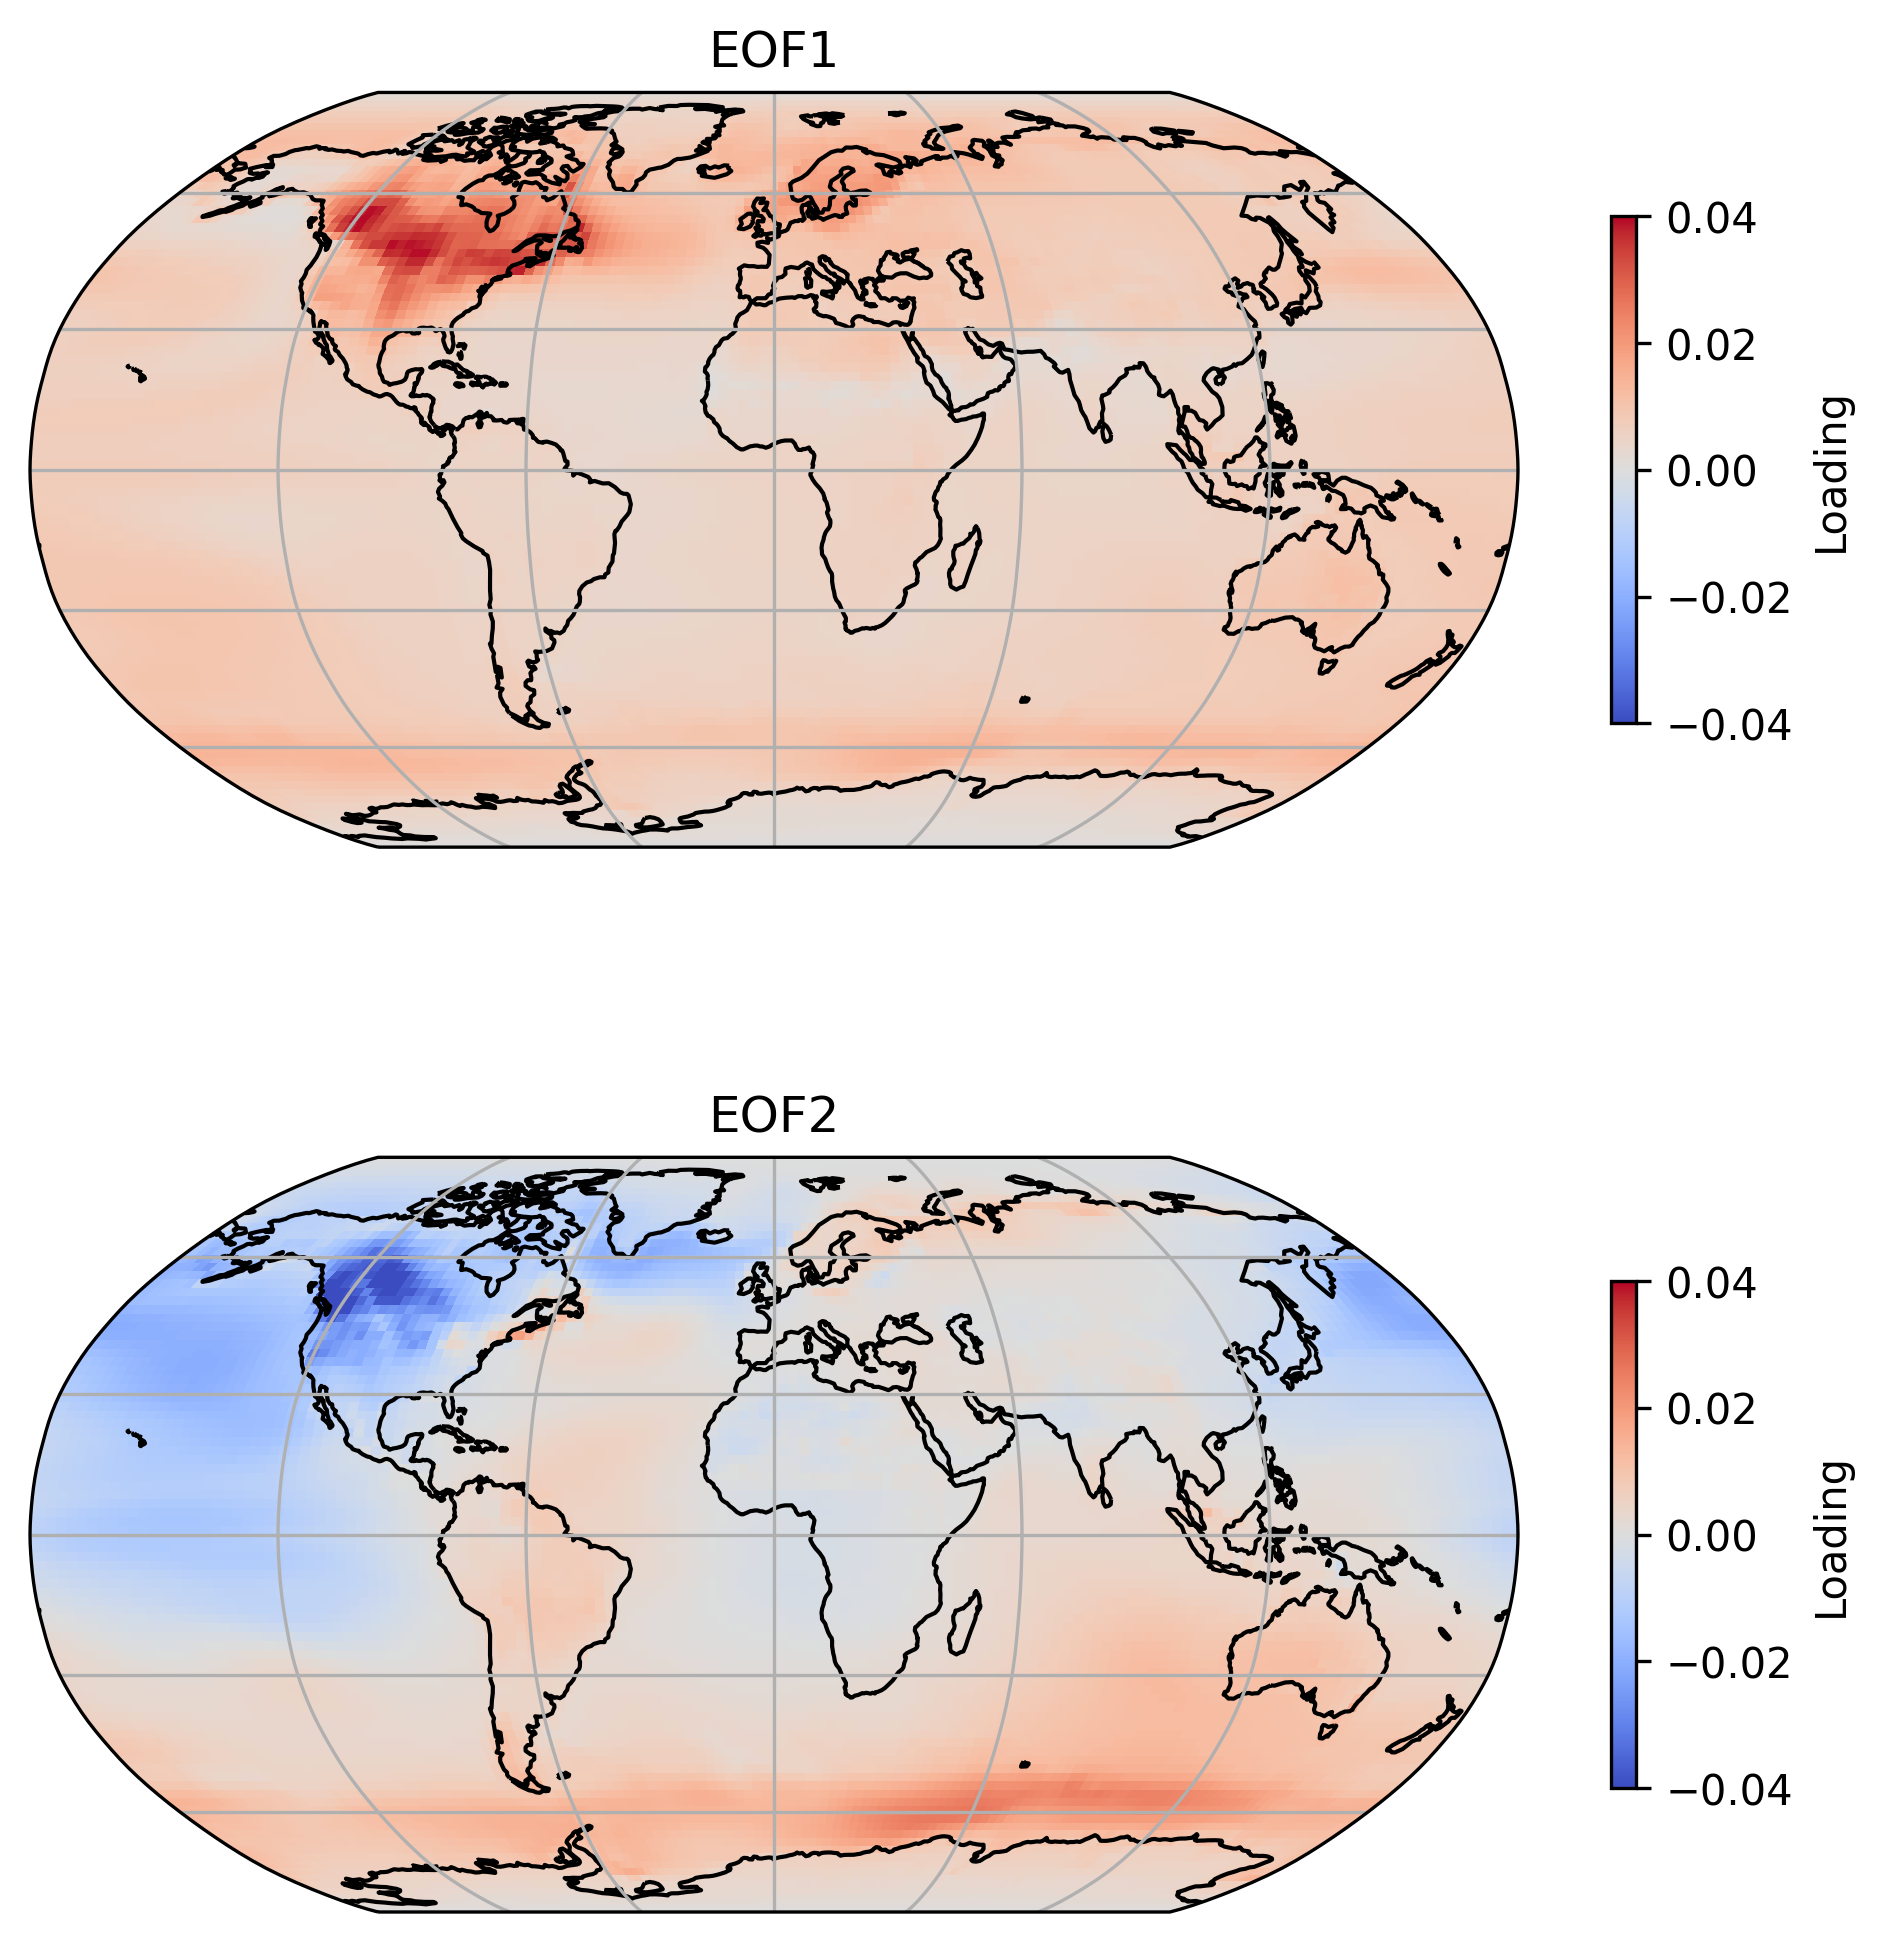

In [4]:
from toolbox import PCA_functions as pf
# 4. Perform PCA
exp_v_climo, eofs_climo, pcs_climo = pf.sat_PCA(ds_sat)
print('Explained variance:', exp_v_climo)

# 5. Plot pcs_climo
pf.plot_pcs(ds_sat['age'].values, pcs_climo, exp_v_climo)

# 6. Plot EOF Scatter
pf.plot_eof_scatter(eofs_climo)

# 7. Plot the EOF Map
pf.plot_eof_map(eofs_climo, ds_sat['lat'].values, ds_sat['lon'].values)

# Save the exp_v, eofs_climo and pcs_climo

In [5]:
# save exp_v_climo, eofs_climo, pcs
import pickle
pickle.dump(exp_v_climo, open('climo_ana_data/exp_v_climo.pkl', 'wb'))
pickle.dump(eofs_climo, open('climo_ana_data/eofs_climo.pkl', 'wb'))
pickle.dump(pcs_climo, open('climo_ana_data/pcs_climo.pkl', 'wb'))

In [6]:
# load exp_v_climo, eofs_climo, pcs
import pickle
exp_v_climo = pickle.load(open('climo_ana_data/exp_v_climo.pkl', 'rb'))
eofs_climo = pickle.load(open('climo_ana_data/eofs_climo.pkl', 'rb'))
pcs_climo = pickle.load(open('climo_ana_data/pcs_climo.pkl', 'rb'))

# PCA, using sklearn

shape of the reshaped sat_centered_weighted: (65, 13824)
shape of PCs: (65, 2)
Explained variance: [0.89825857 0.08048399]
shape of EOFs: (13824, 2)
Explained variance: [0.89825857 0.08048399]


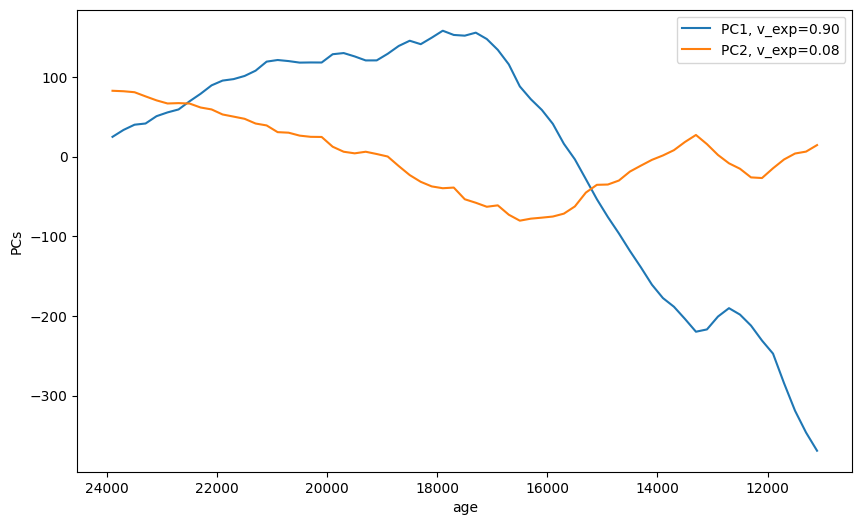

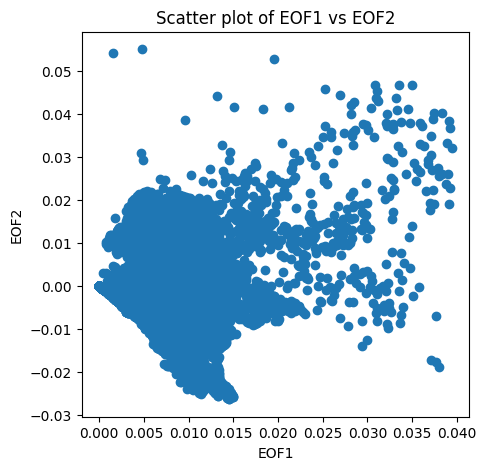

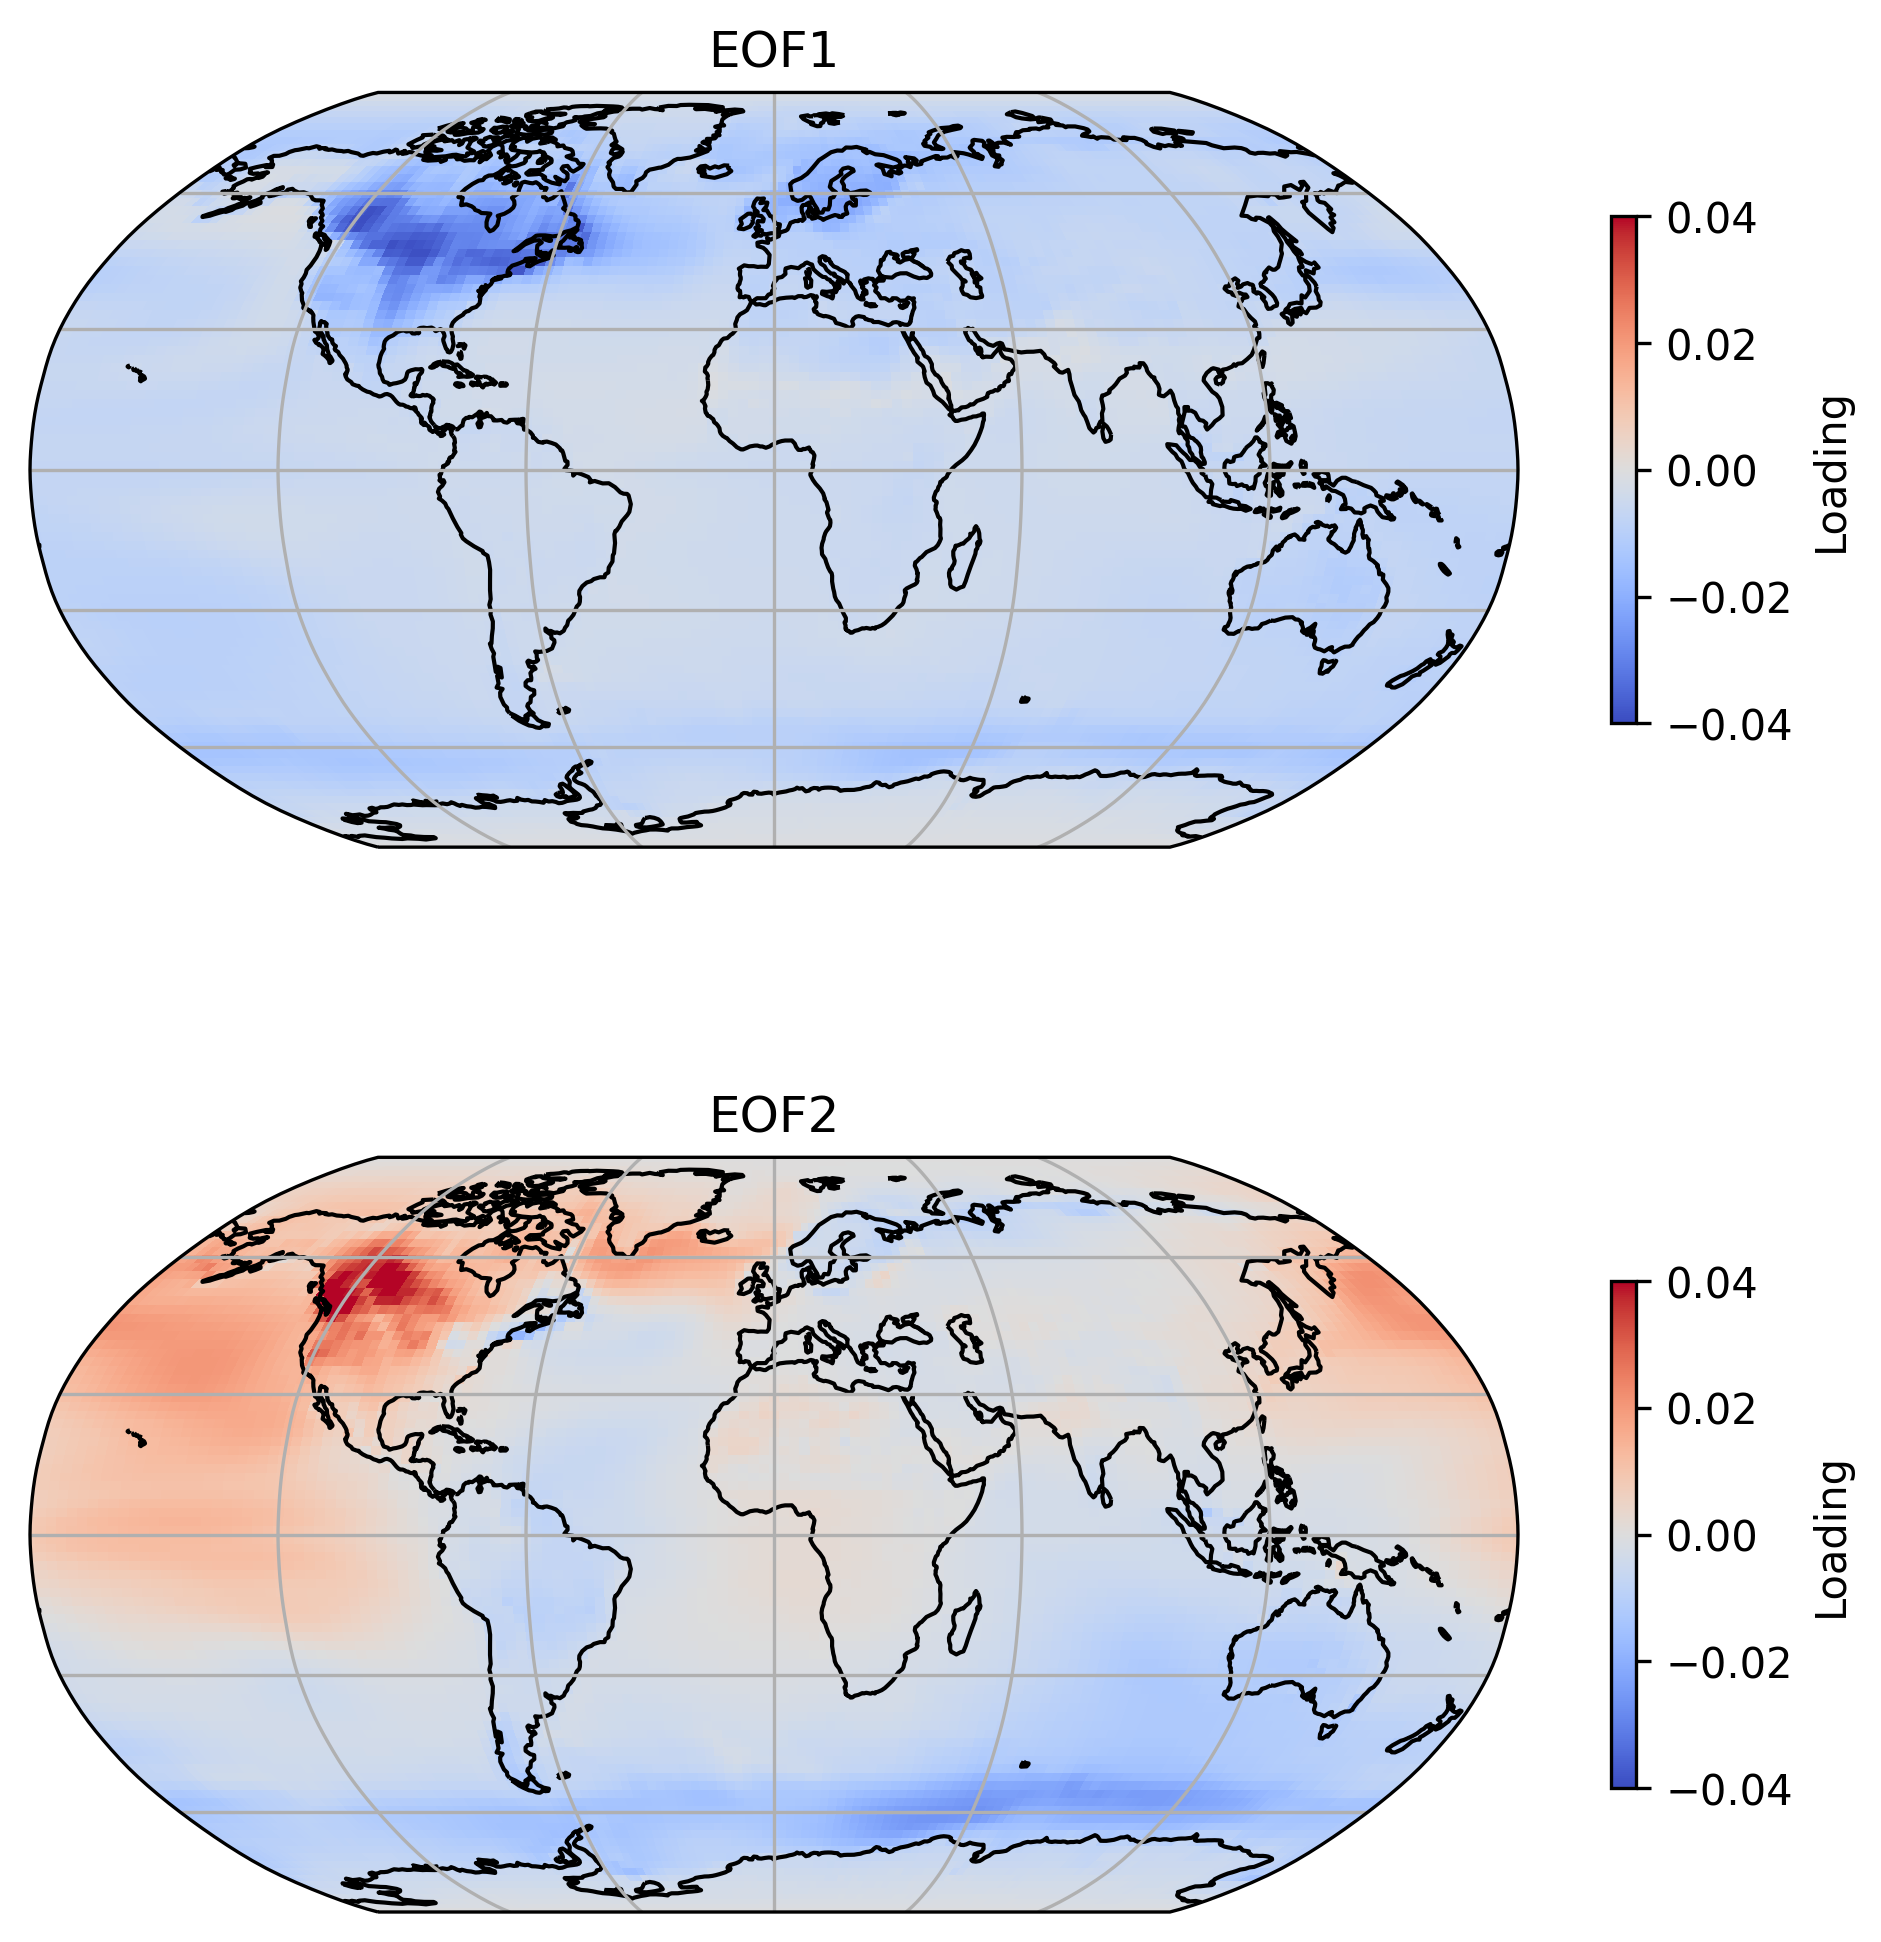

In [5]:
from toolbox import PCA_functions as pf
# 4. Perform PCA
exp_v_climo_sk, eofs_climo_sk, pcs_climo_sk = pf.sat_PCA_sklearn(ds_sat)
print('Explained variance:', exp_v_climo_sk)

# Plot PCs
pf.plot_pcs(ds_sat['age'].values, pcs_climo_sk, exp_v_climo_sk)

# 6. Plot EOF Scatter
pf.plot_eof_scatter(eofs_climo_sk)

# 7. Plot the EOF Map
pf.plot_eof_map(eofs_climo_sk, ds_sat['lat'].values, ds_sat['lon'].values)

# Save the data

In [7]:
# save exp_v_climo_sk, eofs_climo_sk, pcs_climo_sk
import pickle
pickle.dump(exp_v_climo_sk, open('climo_ana_data/exp_v_climo_sk.pkl', 'wb'))
pickle.dump(eofs_climo_sk, open('climo_ana_data/eofs_climo_sk.pkl', 'wb'))
pickle.dump(pcs_climo_sk, open('climo_ana_data/pcs_climo_sk.pkl', 'wb'))

In [ ]:
# read exp_v_climo_sk, eofs_climo_sk, pcs_climo_sk
import pickle
exp_v_climo_sk = pickle.load(open('climo_ana_data/exp_v_climo_sk.pkl', 'rb'))
eofs_climo_sk = pickle.load(open('climo_ana_data/eofs_climo_sk.pkl', 'rb'))
pcs_climo_sk = pickle.load(open('climo_ana_data/pcs_climo_sk.pkl', 'rb'))

# GMM

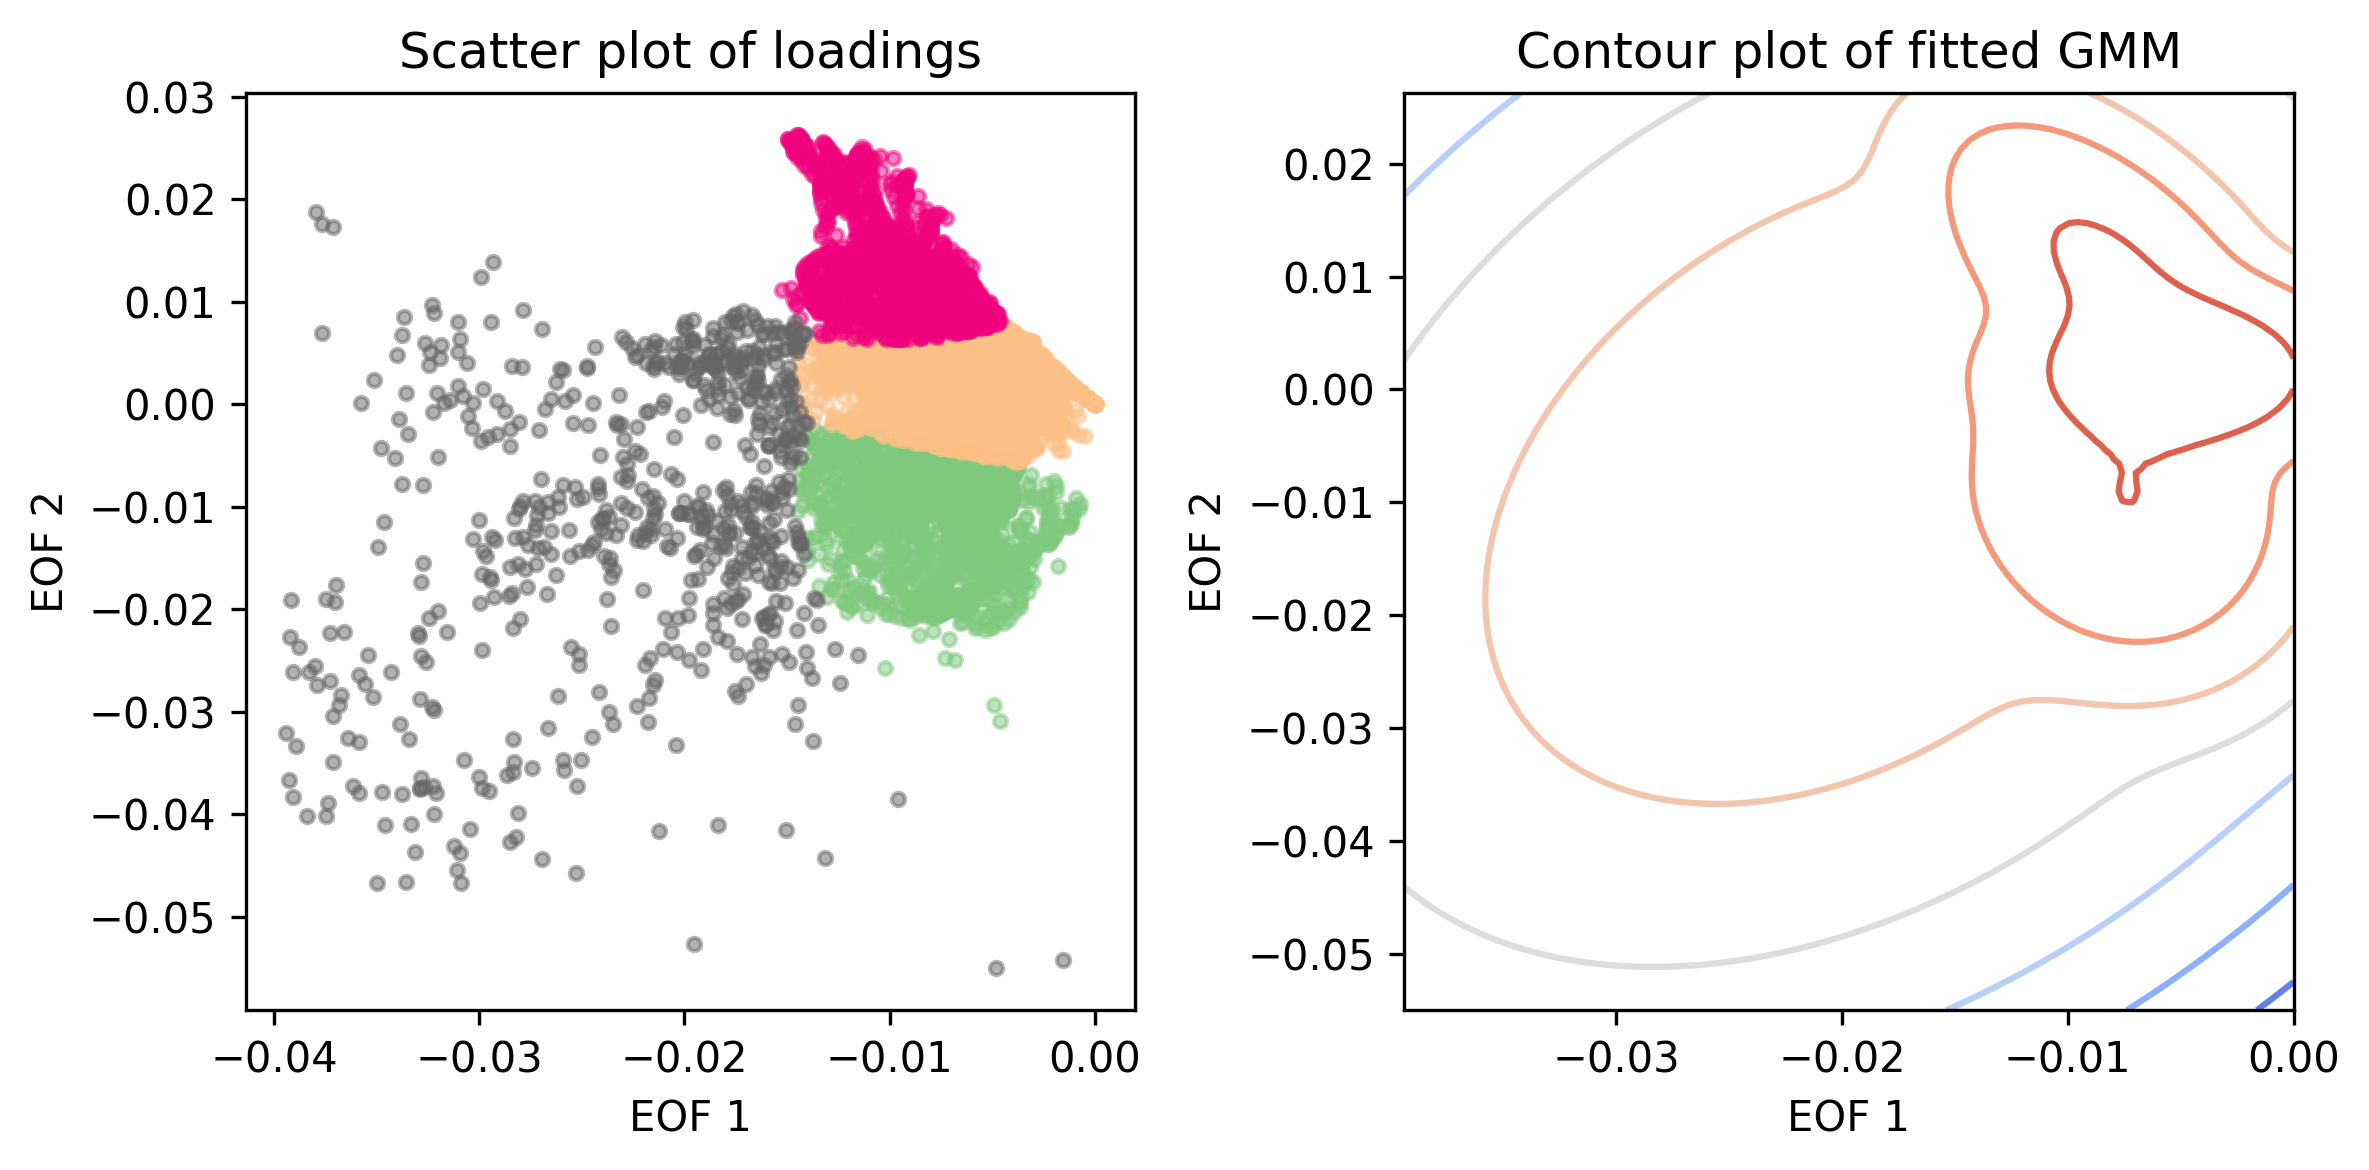

In [7]:
from toolbox import GMM_functions_single as gfs
ds_GMM_climo=gfs.GMM4EOFS(eofs_climo, ds_sat,n_components=4)

# Store the GMM results

In [8]:
# save the ds_EOFs_GMM
ds_GMM_climo.to_netcdf('climo_ana_data/ds_GMM_climo.nc')

In [4]:
# load the ds_EOFs_GMM
import xarray as xr
ds_GMM_climo = xr.open_dataset('climo_ana_data/ds_GMM_climo.nc')

# Plot the spatial distribution of labels

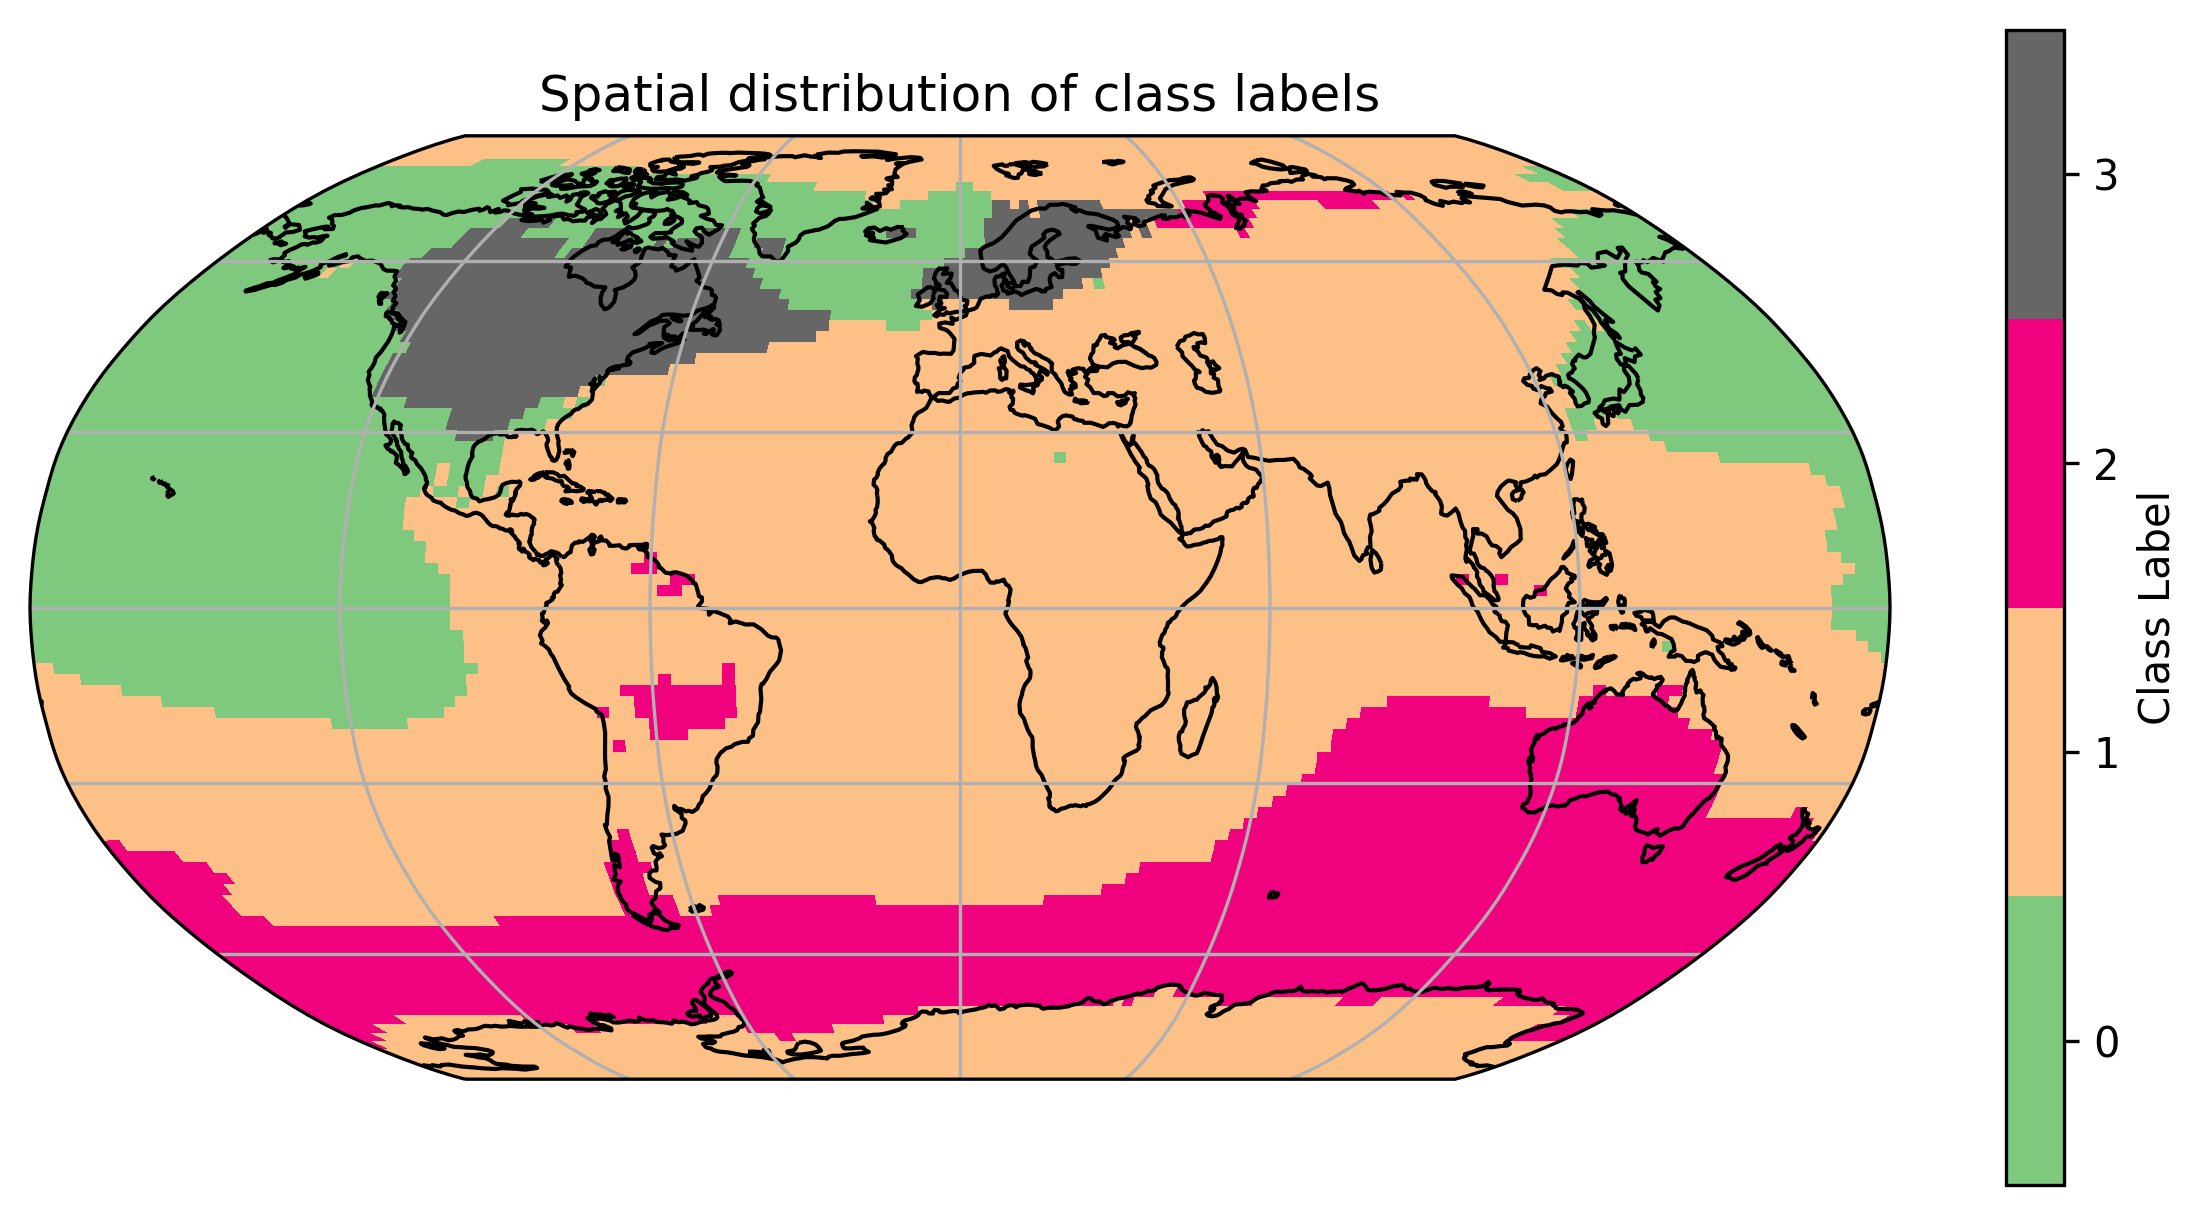

In [5]:
from toolbox import GMM_functions_single as gfs
gfs.plot_labels(ds_GMM_climo)

# Plot the weighted average curves

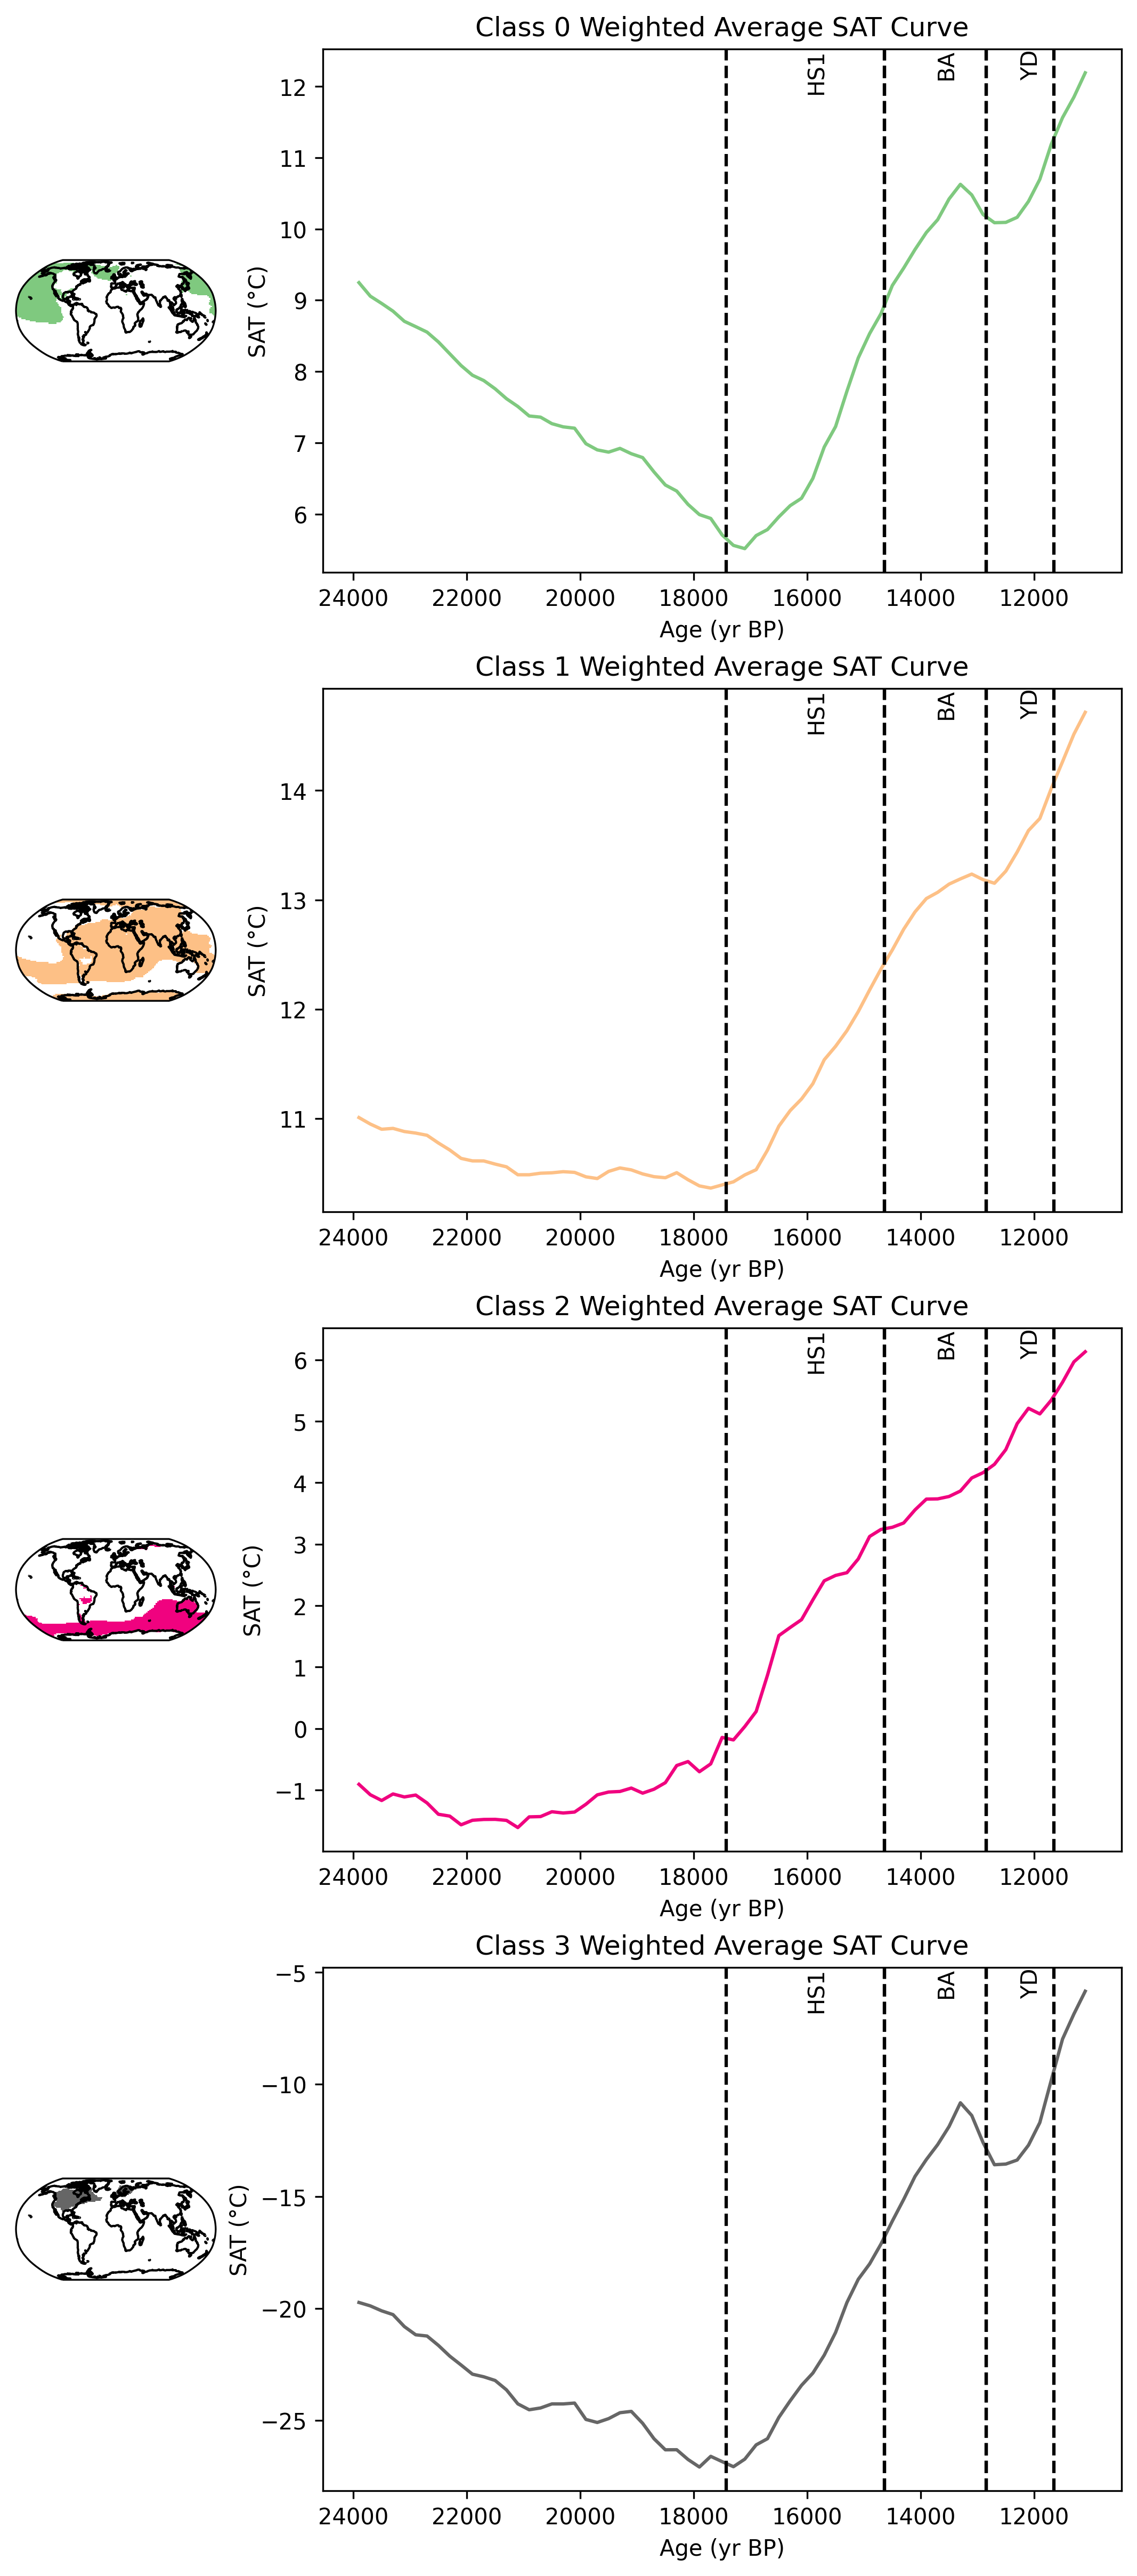

In [3]:
from toolbox import GMM_functions_single as gfs
uncor_weighted_avg=gfs.plot_weighted_average_curve(ds_GMM_climo.copy(), dpi=300)

In [5]:
# store the uncor_weighted_avg
import pickle
pickle.dump(uncor_weighted_avg, open('climo_ana_data/uncor_weighted_avg.pkl', 'wb'))

In [1]:
# load the uncor_weighted_avg
import pickle
uncor_weighted_avg = pickle.load(open('climo_ana_data/uncor_weighted_avg.pkl', 'rb'))

# Find change points


INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast.irreg(),set print.options = 0 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast.irreg(),      set quiet = 1 

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 55
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 (unknown unit)
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend       : False | I

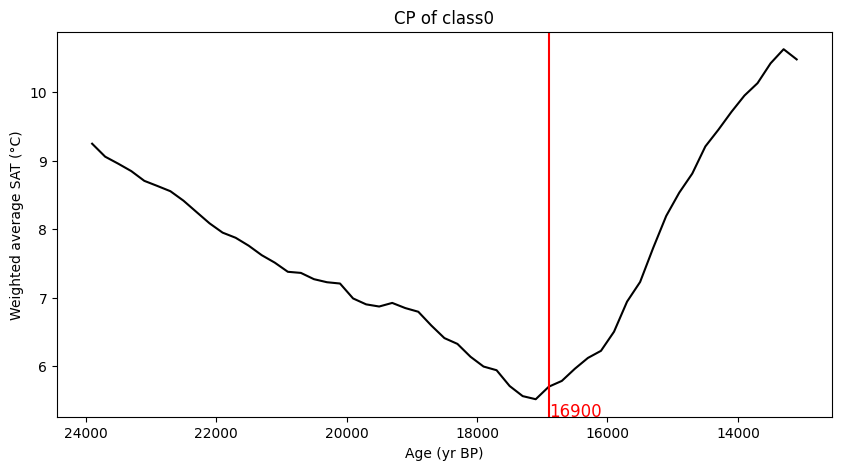

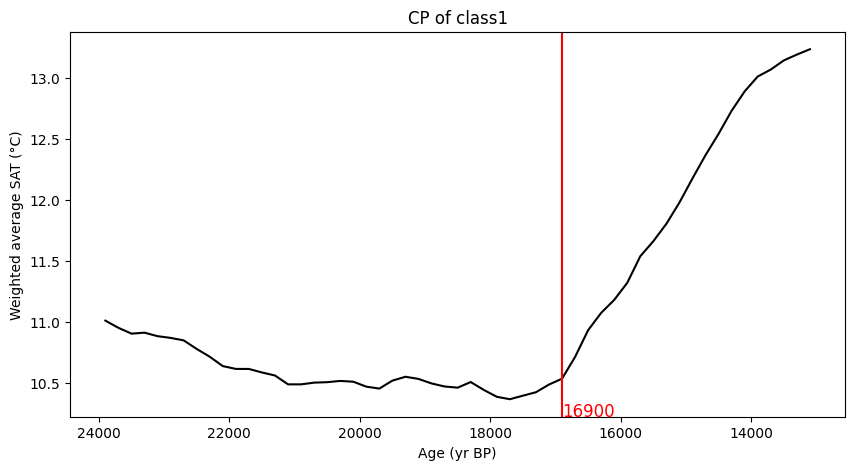

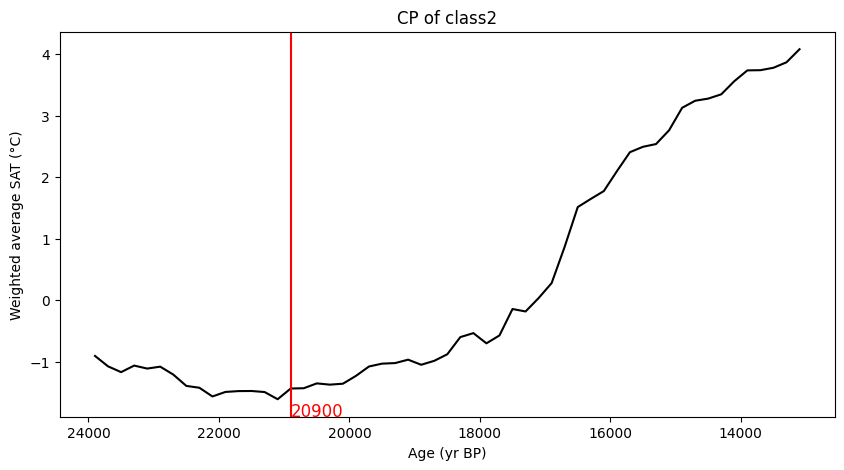

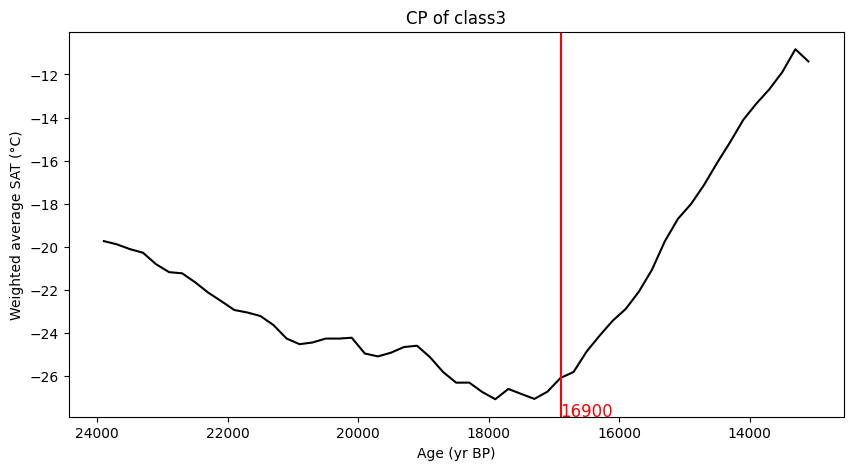

In [3]:
from toolbox import change_point_functions as cpf
unsorted_cp={}
for i in range(len(uncor_weighted_avg)):
    cp_climo_info=cpf.find_cp(uncor_weighted_avg[i], ds_GMM_climo['age'].values, avg_plot=True, avg_plot_title=f'CP of class{i}')
    unsorted_cp[i]=cp_climo_info['cp_age']


# Store the cp_climo_info

In [13]:
# save the 'cp_climo_info'
import pickle
pickle.dump(unsorted_cp, open('climo_ana_data/cp_climo_info.pkl', 'wb'))


In [14]:
# load the cp_climo_info
import pickle
unsorted_cp = pickle.load(open('climo_ana_data/cp_climo_info.pkl', 'rb'))

# Sort the class label according to the cps

In [4]:
from toolbox import change_point_functions as cpf
relabeled_cp, match = cpf.sort_classes_by_cp_age(unsorted_cp)
print("Relabeled Classes:", relabeled_cp)
print("Match Between Unsorted and Sorted Classes:", match)

Relabeled Classes: {0: 20900.0, 1: 16900.0, 2: 16900.0, 3: 16900.0}
Match Between Unsorted and Sorted Classes: {2: 0, 0: 1, 1: 2, 3: 3}


# Relabel the class_label

In [5]:
import numpy as np

ds_GMM_climo_relabeled = ds_GMM_climo.copy()

# Convert the class_label data into a numpy array to work with it directly
original_class_labels = ds_GMM_climo['class_label'].values

# Create a new array for relabeled class labels based on the match dictionary
relabeled_class_labels = np.vectorize(match.get)(original_class_labels)

# Add the new relabeled class labels as a data variable to the dataset
ds_GMM_climo_relabeled['class_relabeled'] = (('lat', 'lon'), relabeled_class_labels)

In [13]:
ds_GMM_climo_relabeled

<xarray.Dataset>
Dimensions:                (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat                    (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                    (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * age                    (age) float32 1.11e+04 1.13e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_std                (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    weight                 (lat) float32 ...
    sat_centered_weighted  (age, lat, lon) float32 ...
    class_label            (lat, lon) int64 ...
    class_relabeled        (lat, lon) int32 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2

In [17]:
# store the ds_GMM_climo_relabeled
ds_GMM_climo_relabeled['lat'].encoding['missing_value'] = np.nan
ds_GMM_climo_relabeled['lon'].encoding['missing_value'] = np.nan
ds_GMM_climo_relabeled.to_netcdf('climo_ana_data/ds_GMM_climo_relabeled.nc')

In [1]:
# load the ds_GMM_climo_relabeled
import xarray as xr
ds_GMM_climo_relabeled = xr.open_dataset('climo_ana_data/ds_GMM_climo_relabeled.nc')

# Plot the spatial distribution of labels

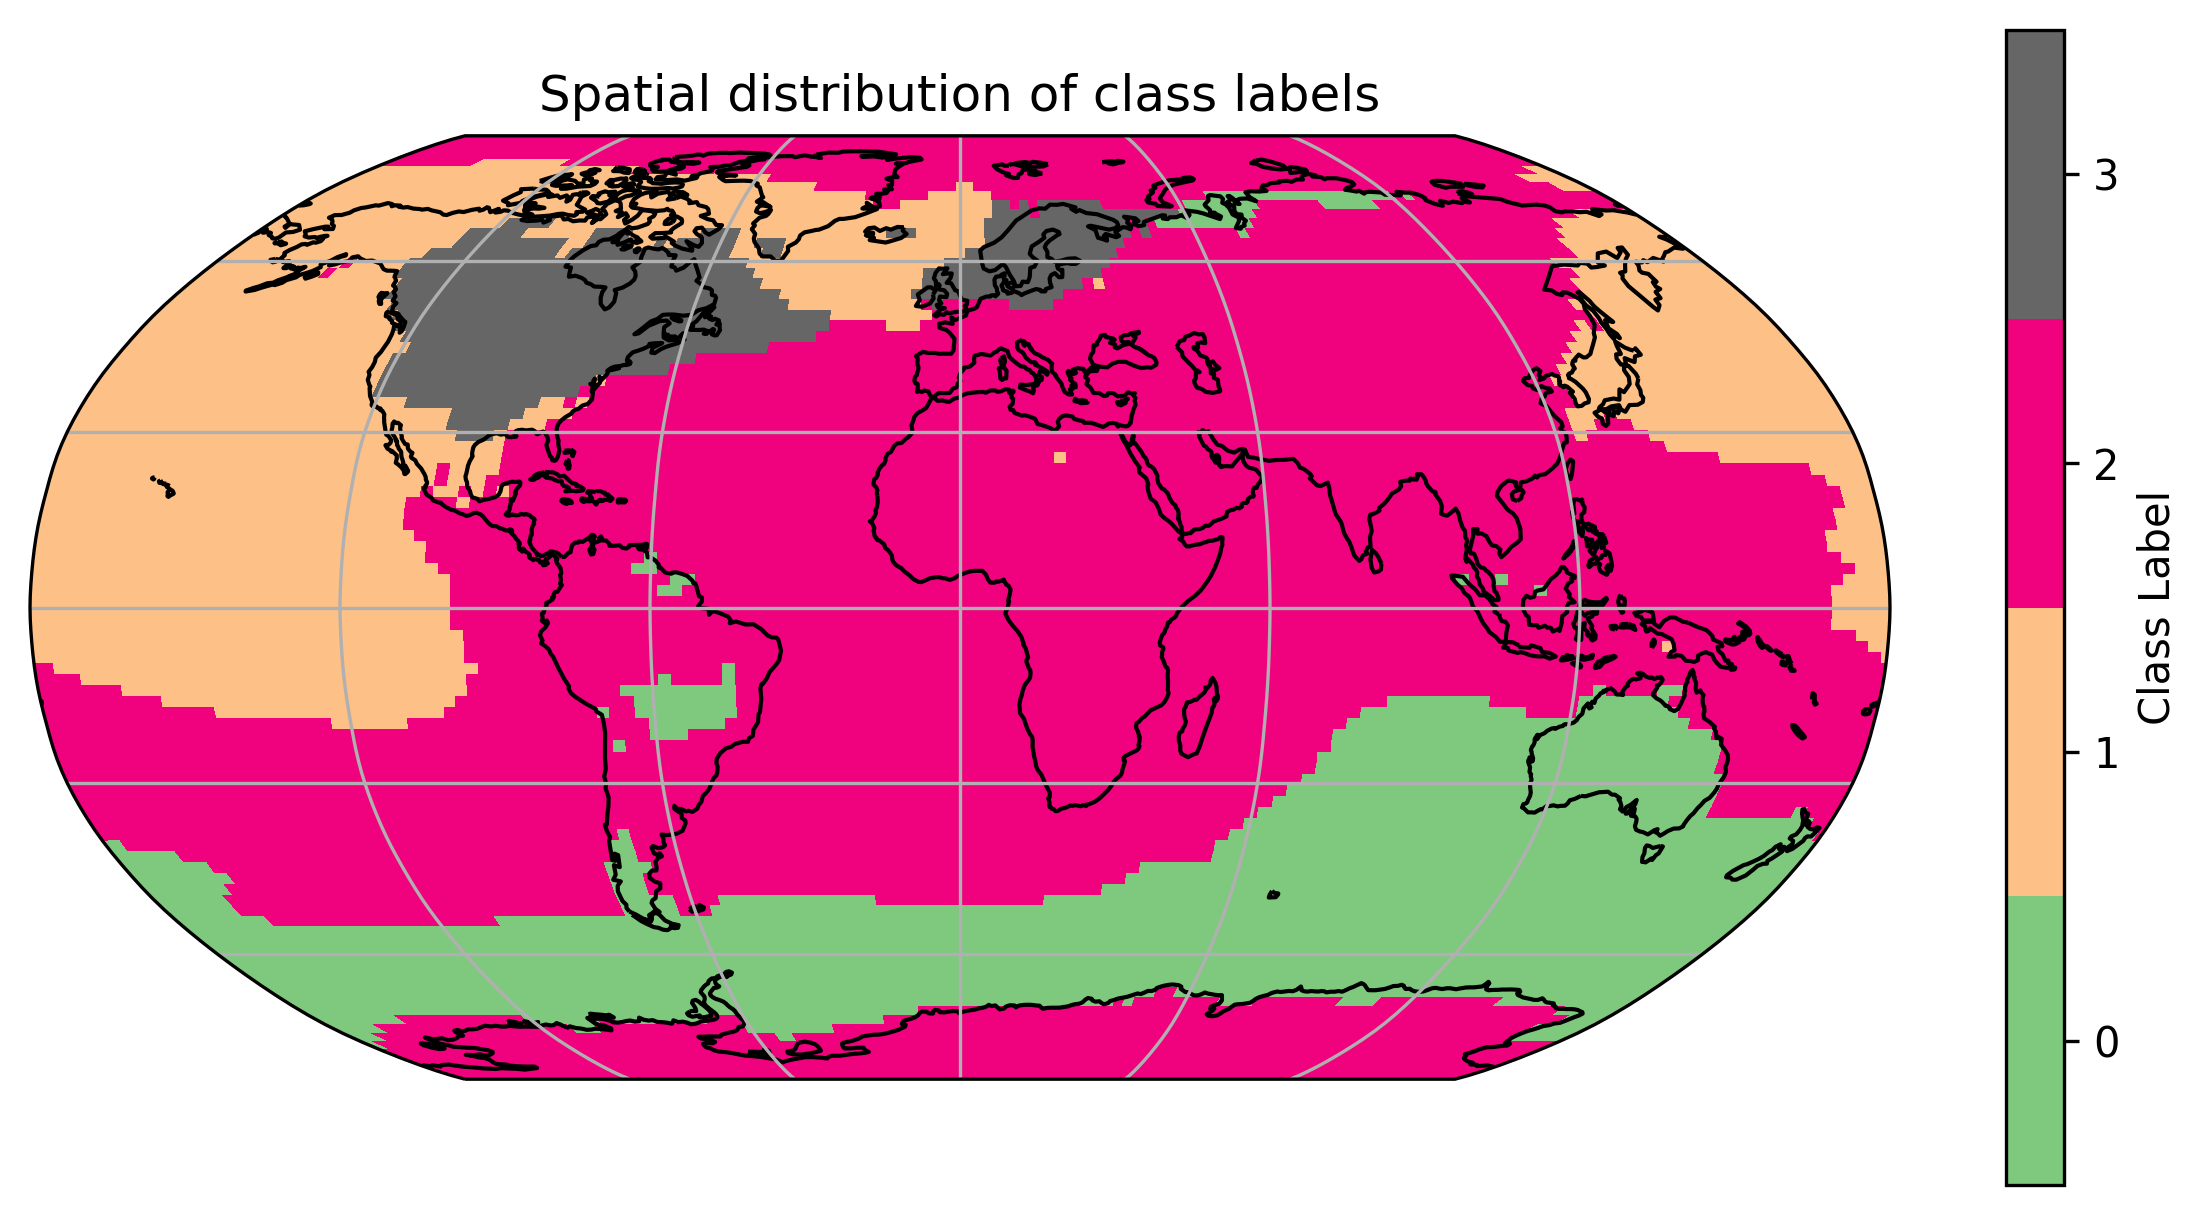

In [6]:

from toolbox import GMM_functions_single as gfs
gfs.plot_labels(ds_GMM_climo_relabeled,label_var_name='class_relabeled')

# Relabel the average curves

In [2]:
from toolbox import change_point_functions as cpf
ds_GMM_climo_relabeled=cpf.cal_anomalies(ds_GMM_climo_relabeled,2000)

relabeled_weighted_avg = {}
for i in range(4):
    relabeled_weighted_avg[i] = cpf.cal_weighted_average_curve(ds_GMM_climo_relabeled, i, sat_var_name='sat_anomalies',class_label_name='class_relabeled')

In [21]:
# relabeled_weighted_avg = {}

# for old_key, new_key in match.items():
#     if old_key in uncor_weighted_avg:
#         # Assign the array from the old key to the new key in the new dictionary
#         relabeled_weighted_avg[new_key] = uncor_weighted_avg[old_key]


In [5]:
# save the relabeled_weighted_avg
import pickle
pickle.dump(relabeled_weighted_avg, open('climo_ana_data/relabeled_weighted_avg.pkl', 'wb'))


In [6]:
# read the relabeled_weighted_avg
import pickle
relabeled_weighted_avg = pickle.load(open('climo_ana_data/relabeled_weighted_avg.pkl', 'rb'))


INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast.irreg(),set print.options = 0 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast.irreg(),      set quiet = 1 

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 55
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 (unknown unit)
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend       : False | I

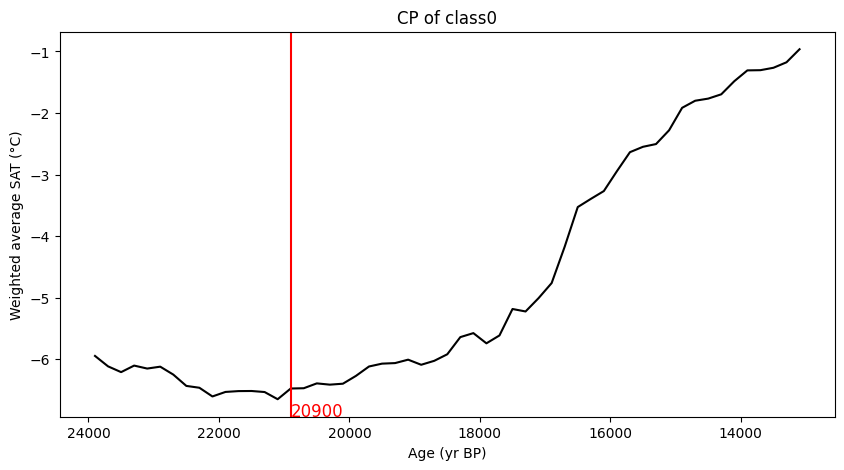

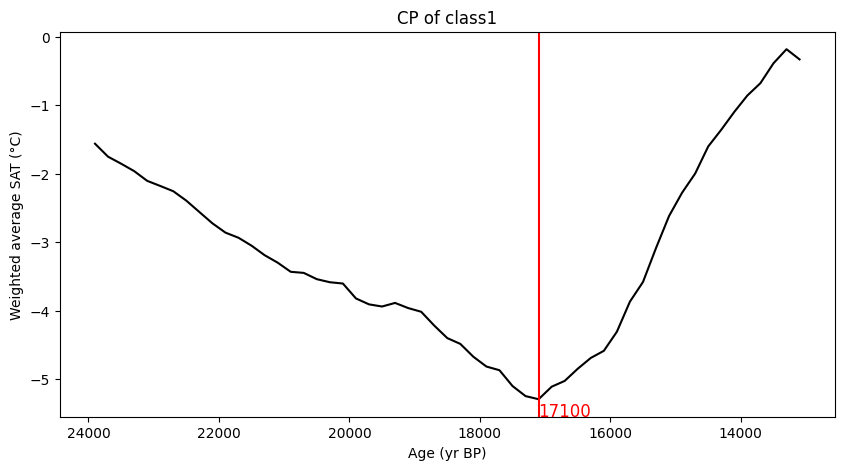

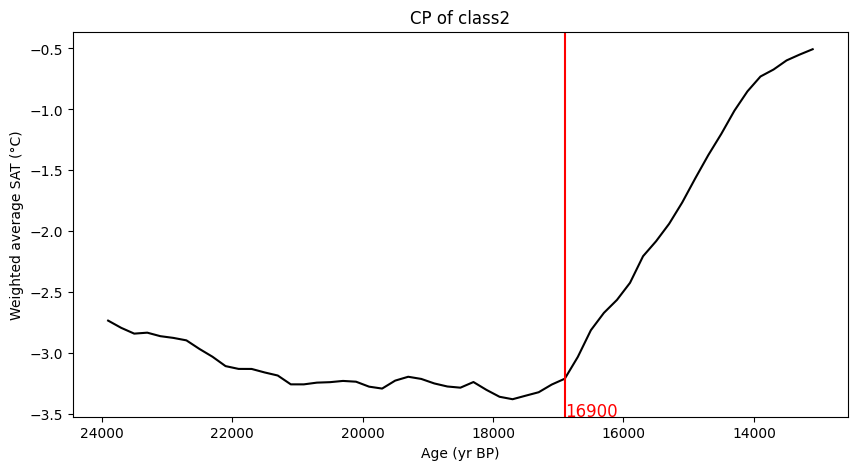

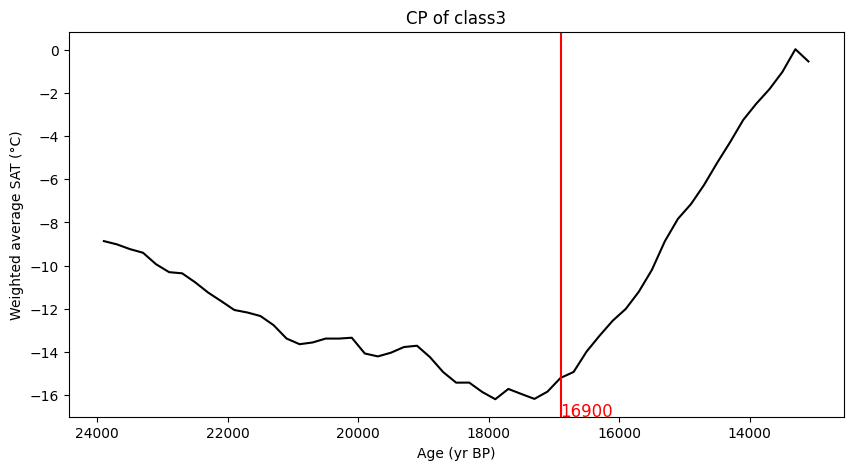

In [4]:
from toolbox import change_point_functions as cpf

for i in range(len(relabeled_weighted_avg)):
    cp_climo_info_relabeled=cpf.find_cp(relabeled_weighted_avg[i], ds_GMM_climo_relabeled['age'].values, avg_plot=True, avg_plot_title=f'CP of class{i}')

# GMM on the sklearn PCA results

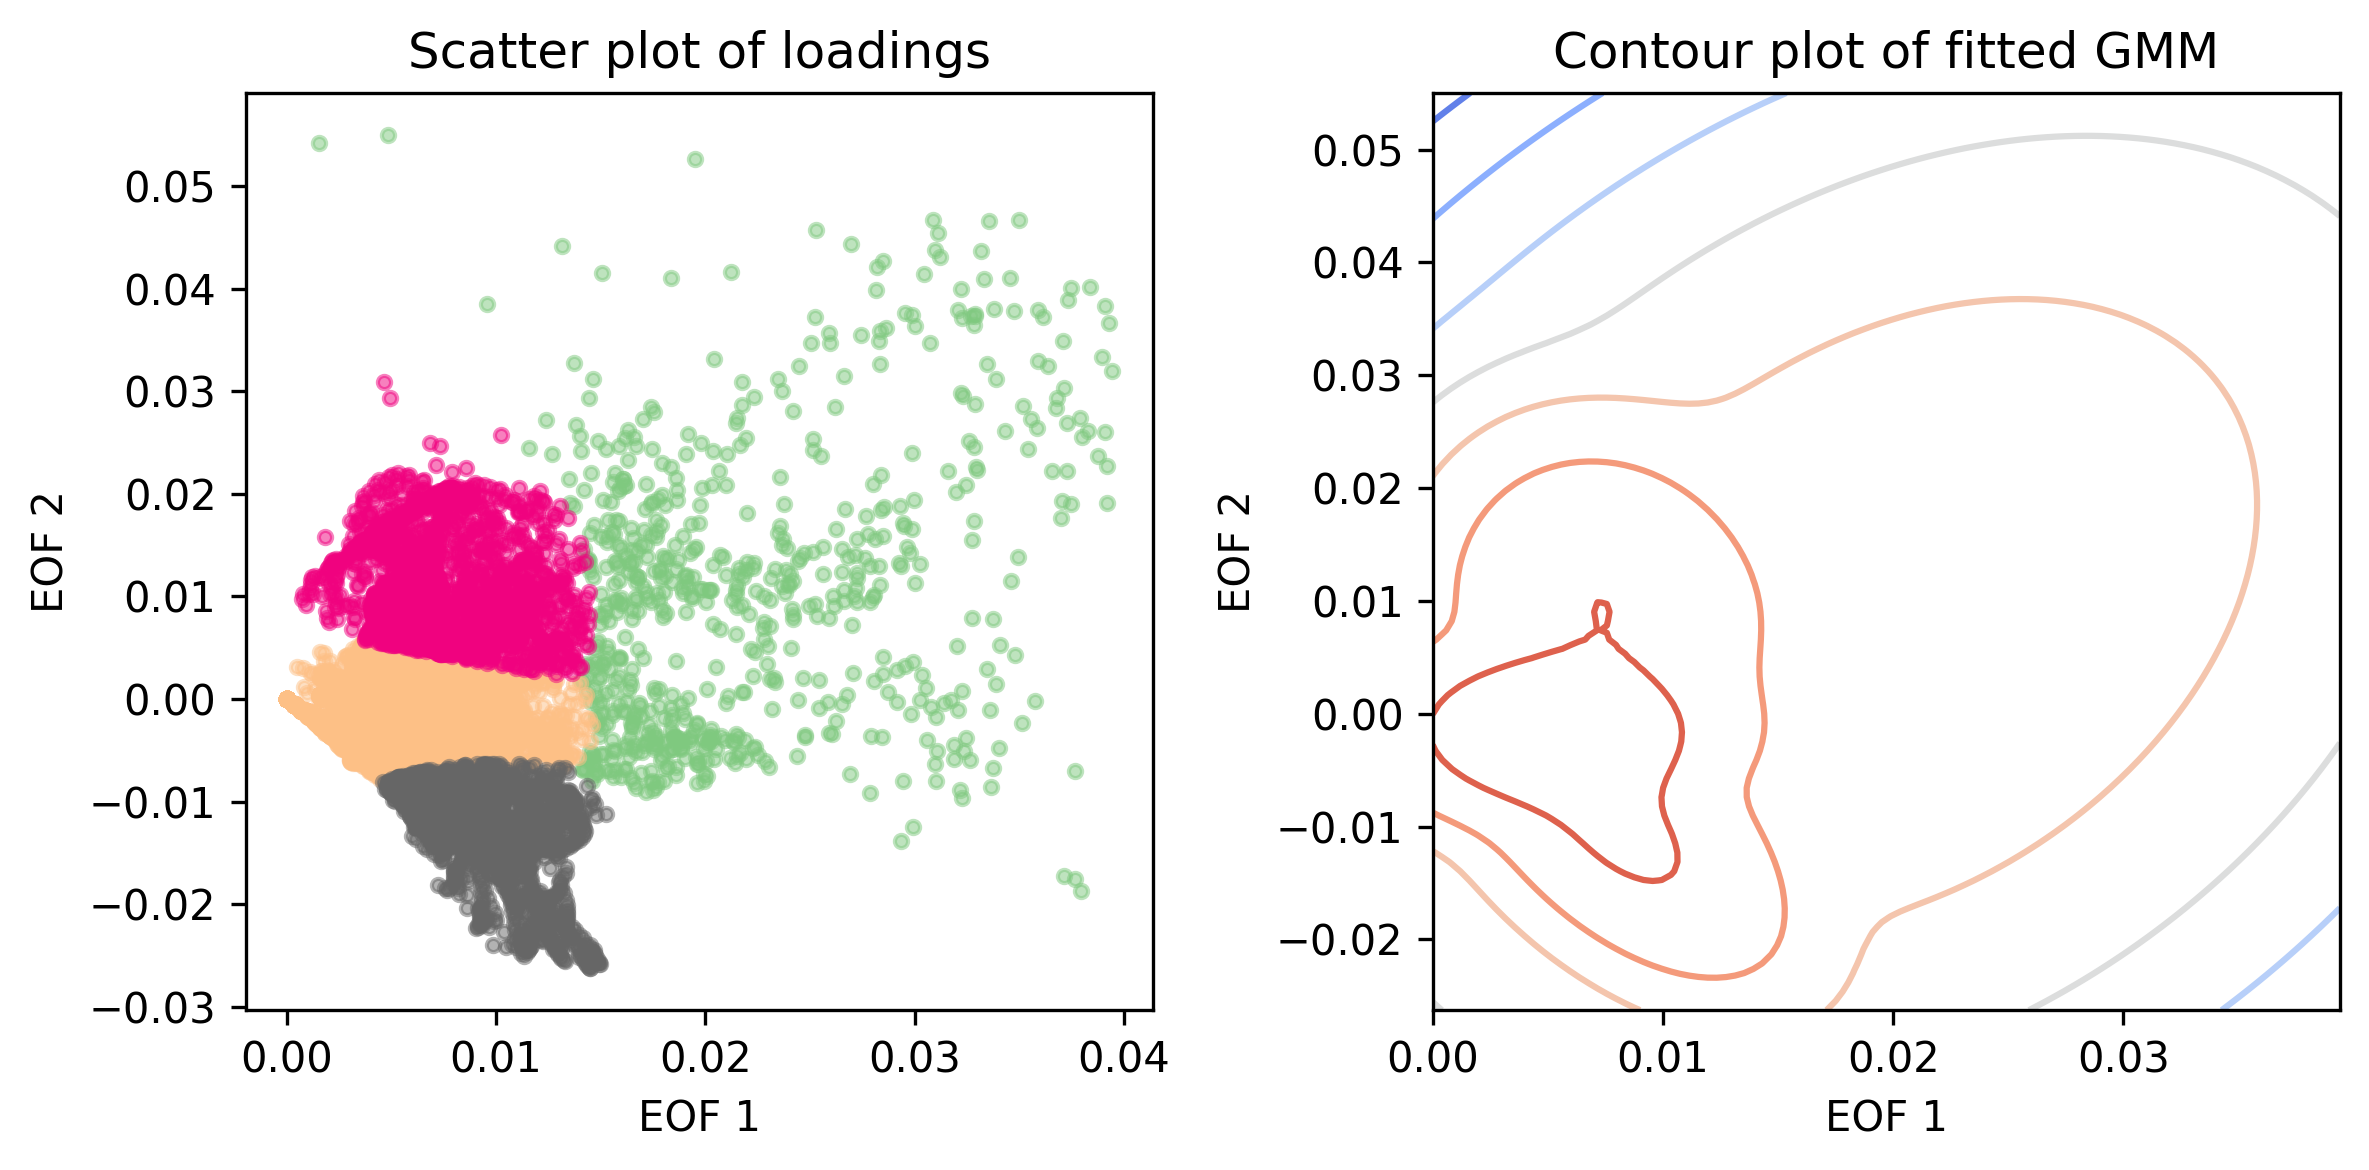

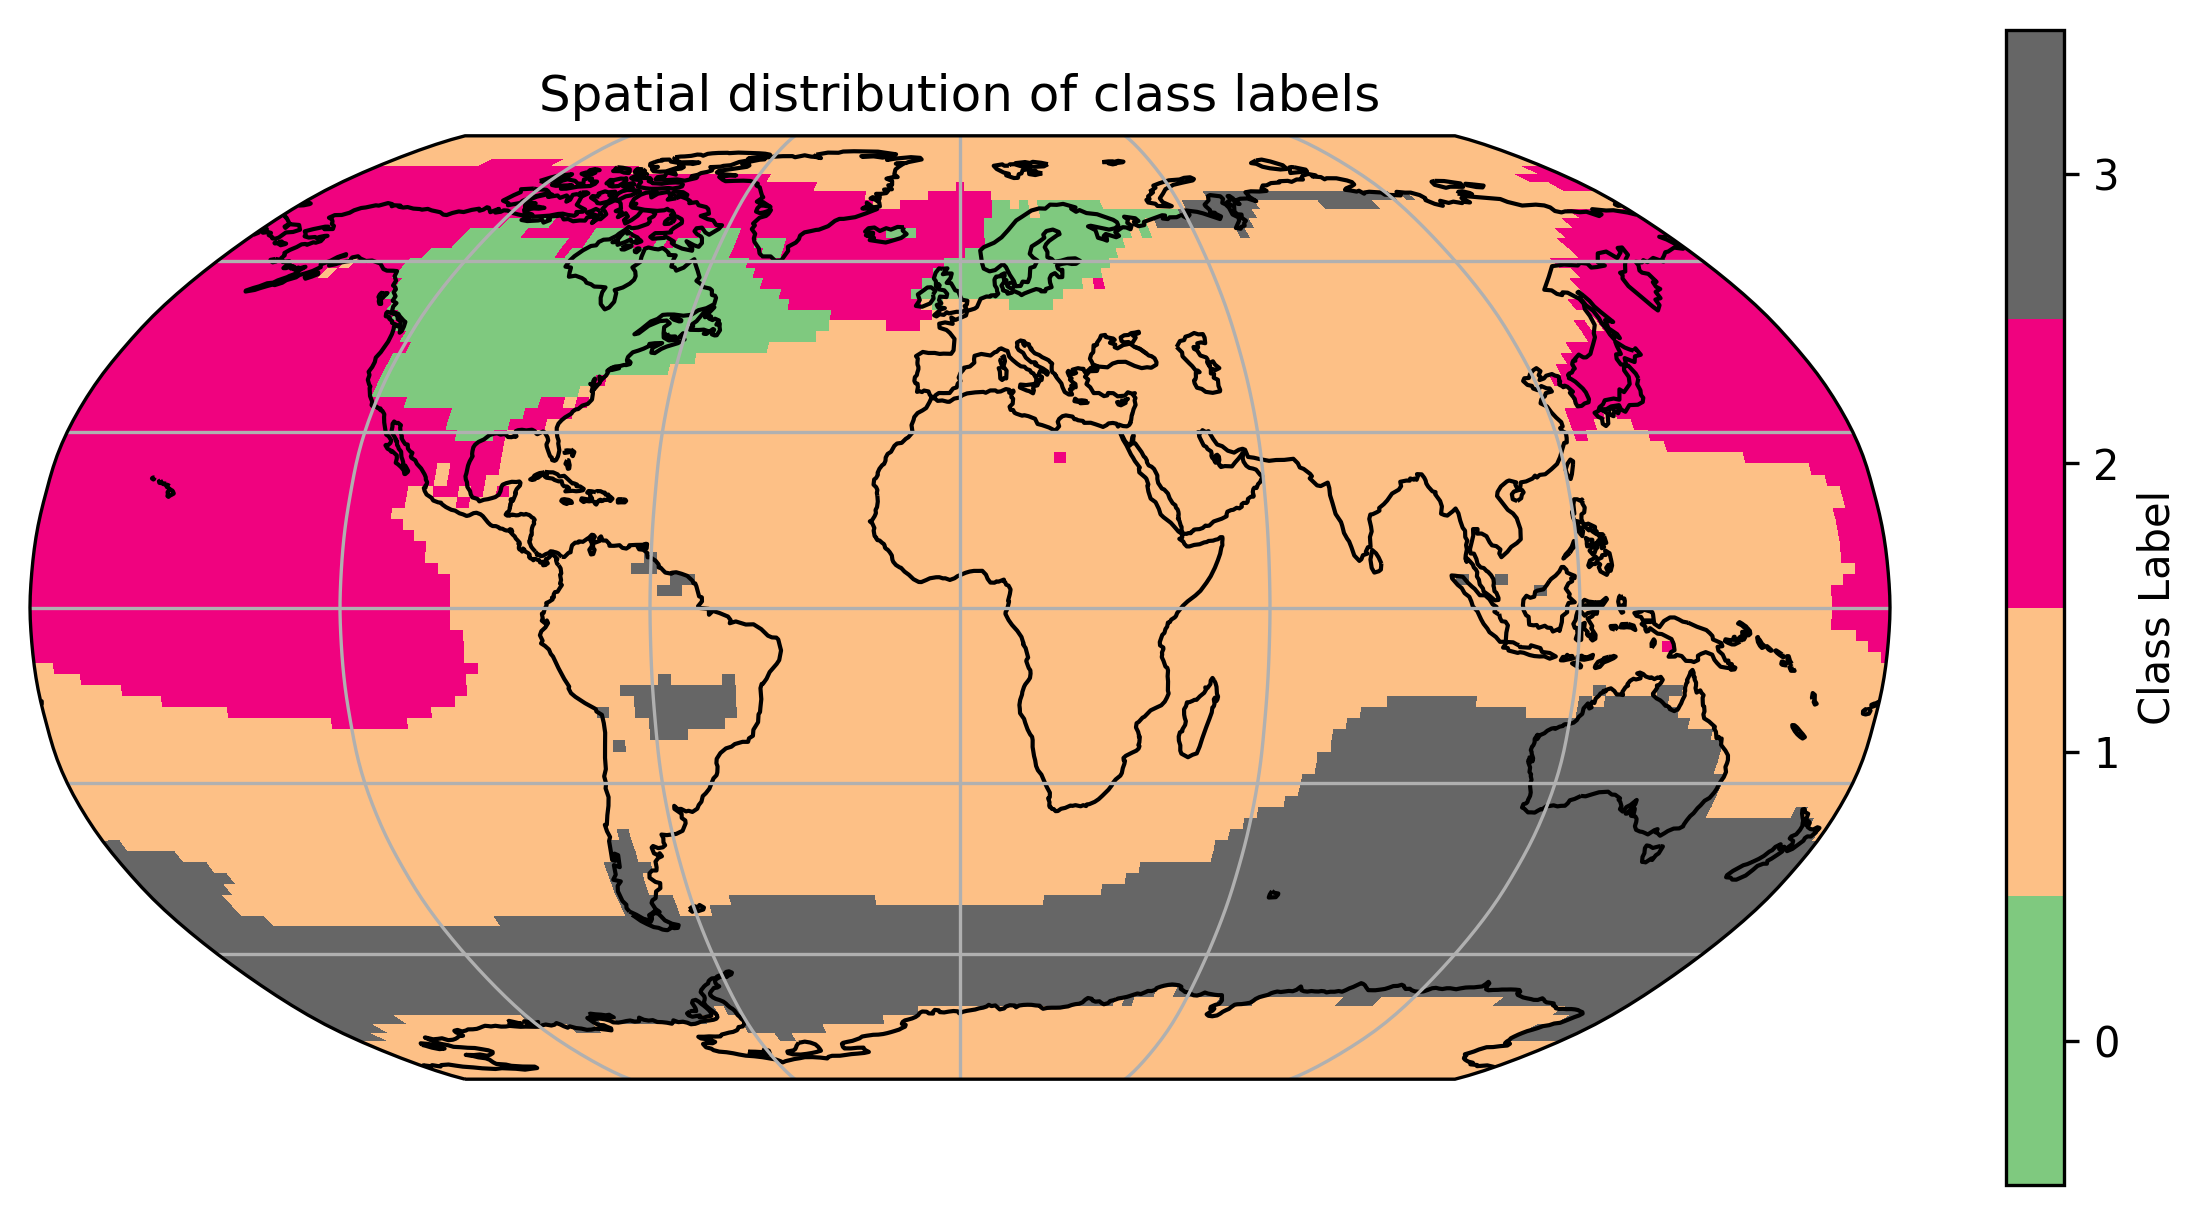

In [6]:
from toolbox import GMM_functions_single as gfs
ds_EOFs_GMM=gfs.GMM4EOFS(eofs_climo_sk, ds_sat,n_components=4)
gfs.plot_labels(ds_EOFs_GMM)